# Preliminary operation and Import Packages

2.9 version of TensorFlow/Keras, because some data augmentation techniques are particularly slow

In [ ]:
%pip install tensorflow-gpu==2.8.3 
%pip install -U scikit-learn

In [ ]:
!nvidia-smi

Mon Feb  6 21:40:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |    214MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3053378521526046220
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1297474971
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2118325974425920900
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras import regularizers
from tensorflow import initializers
from keras.layers import LSTM
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Activation

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Image management
import cv2

from time import time
import sys
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils import class_weight 

import pydot
import pydotplus
from pydotplus import graphviz

In [ ]:
# Set the directory where the label  is stored

# path = 'C:/Users/marco/Desktop/Local_Documents/data'
# os.chdir(path=path)

In [ ]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [10,10] # width, height

# Image low-level processing

In this section different techniques for low-level processing of CXR images are explored

In [ ]:
os.chdir('C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train')

In [ ]:
im = cv2.imread('COVID-19\\0a6c60063b4bae4de001caaba306d1_jumbo.png')
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

In [ ]:
# Image size
print('Image Dimension: ',im.shape)

Image Dimension:  (224, 224, 3)


The size of the image is 224x224 and has 3 channels (RGB).

In order to carry out the necessary preprocessing, it is decided to convert a image to grayscale

In [ ]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
# Image size
print('Image Dimension: ',im.shape)

Image Dimension:  (224, 224)


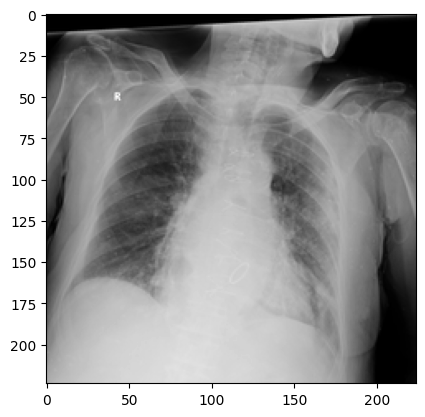

In [ ]:
plt.imshow(im, cmap="gray")

## Gamma correction

In [ ]:
# Function for apply gamma correction 

def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [ ]:
im_gamma = adjust_gamma(im, gamma=0.6)

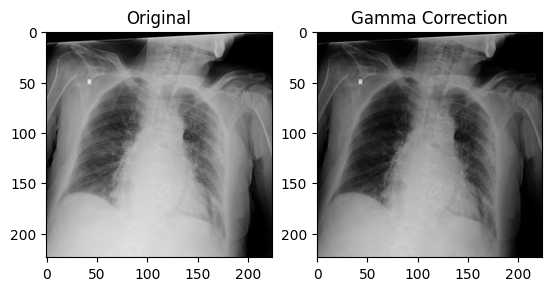

In [ ]:
plt.subplot(1,2,1); plt.imshow(im, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(im_gamma, cmap="gray"); plt.title('Gamma Correction')
plt.show()

## Adaptive Gamma Correction

Le seguenti funzioni implementano l'alogiritmo Adaptive Gamma Correction:

La funzione image_agcwd è il cuore dell'Adaptive Gamma Correction. La funzione riceve un'immagine e i parametri *a* e *truncated_cdf*, che determinano la forma della correzione. La funzione calcola l'istogramma dell'immagine, normalizza la distribuzione cumulativa e la distribuzione di probabilità. Poi esegue una trasformazione sulla distribuzione di probabilità, calcola la distribuzione cumulativa inversa e la utilizza per correggere la luminosità dell'immagine.

Infine, le funzioni **process_bright** e **process_dimmed** invocano la funzione **image_agcwd** con i parametri opportuni per elaborare le immagini luminose e oscure, rispettivamente.



1)  Lettura delle immagini dalla directory di input e creazione della directory di output se non esiste.
2)  Conversione di ogni immagine dal formato BGR a YCrCb.
3)  Calcolo della media di intensità dell'immagine Y (canale della luminosità).
4)  Determinazione della luminosità dell'immagine:
    -   Se la media di intensità è inferiore a una soglia, l'immagine viene considerata "oscura" e viene elaborata con la funzione process_dimmed.
    -   Se la media di intensità è superiore a una soglia, l'immagine viene considerata "luminosa" e viene elaborata con la funzione process_bright.
    -   Altrimenti, l'immagine viene considerata "corretta" e non viene elaborata.
5)  Salvataggio delle immagini elaborate nella directory di output.

In [ ]:
def image_agcwd(img, a=0.25, truncated_cdf=False):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
    if truncated_cdf: 
        inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    else:
        inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
    return img_new

def process_bright(img):
    img_negative = 255 - img
    agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
    return agcwd

This function applies the *Adaptive Gamma Correction* over the whole train dataset

In [ ]:
def apply_AGCWD(input_dir, output_dir):
    img_paths = glob.glob(input_dir+'*')
    total_count= 0
    dimmed_count= 0
    brighted_count = 0
    for path in img_paths:
        total_count +=1
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert to BGR
        # img = cv2.resize(img, (224,224)) # Resize to 224x224
        name = path.split('\\')[-1].split('.')[0]
        
        # Extract intensity component of the image
        YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        Y = YCrCb[:,:,0]
        # Determine whether image is bright or dimmed
        threshold = 0.3
        exp_in = 112 # Expected global average intensity 
        M,N = img.shape[:2]
        mean_in = np.sum(Y/(M*N)) 
        t = (mean_in - exp_in)/ exp_in
        
        # Process image for gamma correction
        img_output = None
        if t < -threshold: # Dimmed Image
            dimmed_count += 1
            # print (name + ": Dimmed")
            result = process_dimmed(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        elif t > threshold:
            brighted_count += 1
            # print (name + ":Bright") # Bright Image
            result = process_bright(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        else:
            # print('None')
            img_output = img
            img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)

        cv2.imwrite(output_dir+name+'.png', img_output)
    print("Numero totale di immagini processate: {}".format(total_count))
    print("Numero di immagini dimmed: {}".format(dimmed_count))
    print("Numero di immagini brighted: {}".format(brighted_count))
    return

### Examples AGC

In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/3a81faf3.jpg'
img_paths = glob.glob(input_dir+'*')
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Oscura"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Schiarisce"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

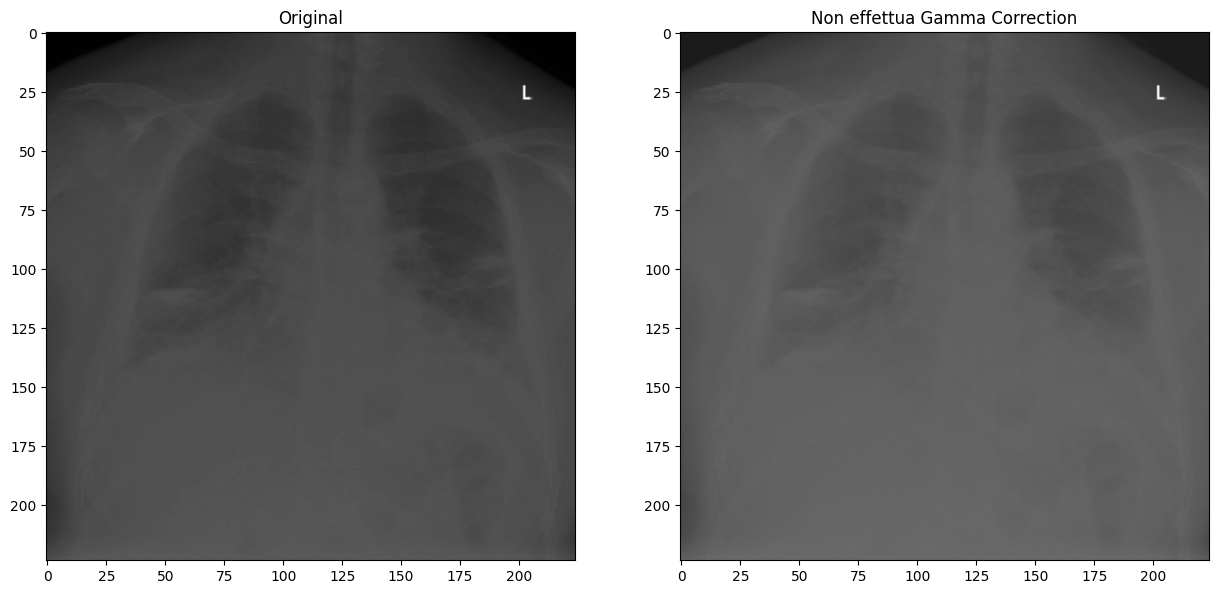

In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/3a81faf3.jpg'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Oscura"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Schiarisce"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

C:/Users/marco/Desktop/Local_Documents/data/train/4b6cf439-a0a3-485f-8de9-950ee632cbca: Bright


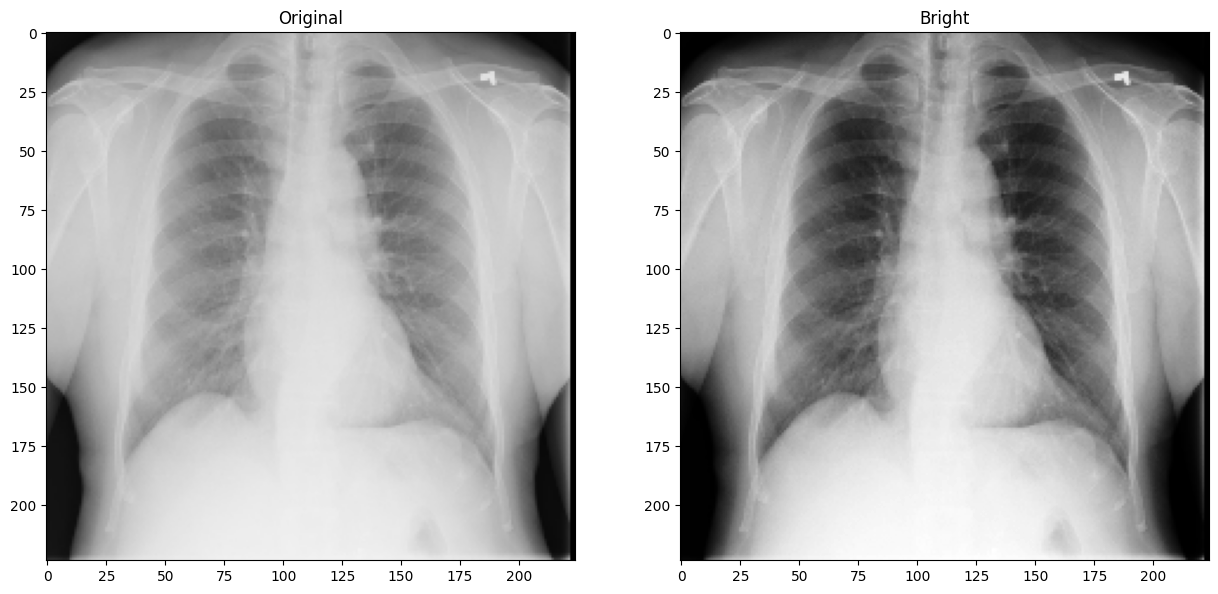

In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/4b6cf439-a0a3-485f-8de9-950ee632cbca.png'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Dimmed"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Bright"
    print (name + ": Bright") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

7a443f19-987a-4fff-a41a-65b9114fe53e: Oscurato


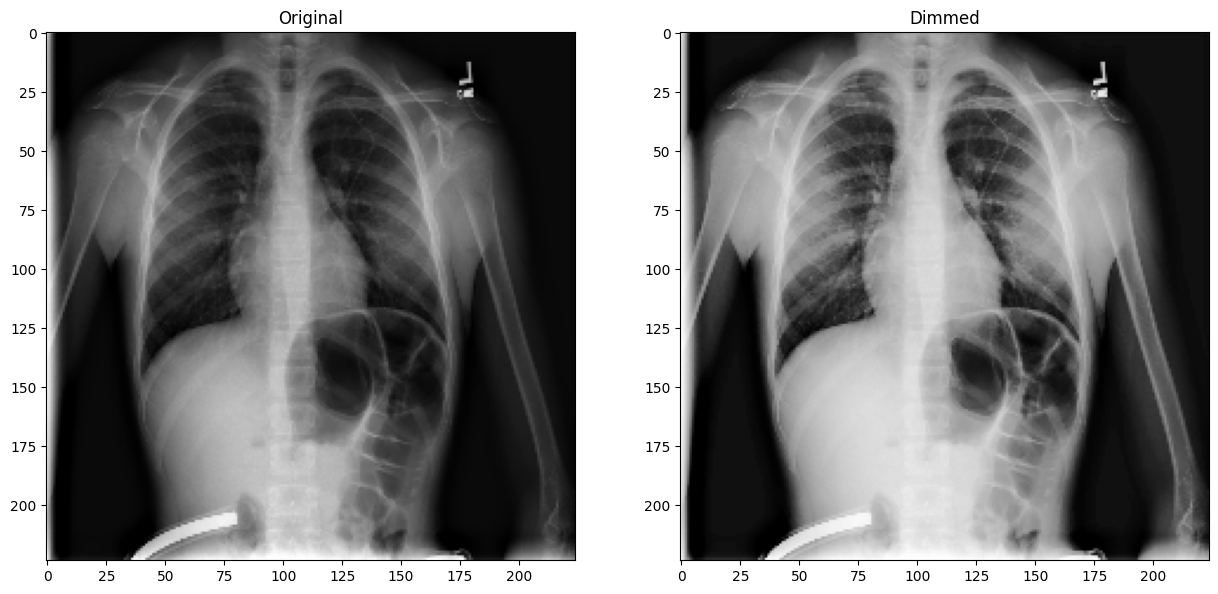

In [ ]:
img_paths = "C:/Users/marco/Desktop/tr/7a443f19-987a-4fff-a41a-65b9114fe53e.png"
output_dir = "C:/Users/marco/Desktop/tr_nuovo/"
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('/')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Dimmed"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Bright"
    print (name + ": Bright") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

### AGC Images 224x224

In [ ]:
# COVID-19 images
input_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train\\COVID-19\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train_agc\\COVID-19\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

Numero totale di immagini processate: 15774
Numero di immagini dimmed: 91
Numero di immagini brighted: 2206


In [ ]:
# Normal images
input_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train\\normal\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train_agc\\normal\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

Numero totale di immagini processate: 8085
Numero di immagini dimmed: 58
Numero di immagini brighted: 1670


In [ ]:
# Pneumonia images
input_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train\\pneumonia\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized\\train_agc\\pneumonia\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

Numero totale di immagini processate: 5545
Numero di immagini dimmed: 94
Numero di immagini brighted: 958


### AGC Images 112x112

In [ ]:
# COVID-19 images
input_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized-112\\train\\COVID-19\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized-112\\train_agc\\COVID-19\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

Numero totale di immagini processate: 15774
Numero di immagini dimmed: 91
Numero di immagini brighted: 2216


In [ ]:
# Normal images
input_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized-112\\train\\normal\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized-112\\train_agc\\normal\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

Numero totale di immagini processate: 8085
Numero di immagini dimmed: 58
Numero di immagini brighted: 1671


In [ ]:
# Pneumonia images
input_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized-112\\train\\pneumonia\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\COVIDx-splitted-resized-112\\train_agc\\pneumonia\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

Numero totale di immagini processate: 5545
Numero di immagini dimmed: 92
Numero di immagini brighted: 958


## Image pre-processing (i.e. crop)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7658227/pdf/41598_2020_Article_76550.pdf

Data pre-processing details:

The COVIDx dataset was used to train all tested deep neural network architectures.
As a pre-processing step, the chest CXR images were **cropped** (top 8% of the image) prior to training in order to mitigate commonly-found embedded textual information in the CXR images. Furthermore, to train the tested deep neural network architectures, **data augmentation** was leveraged with the following augmenta
tion types: translation (± 10% in x and y directions), rotation (± 10. ), horizontal flip, zoom (± 15%), and intensity shift (± 10%).

In [ ]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

In [ ]:
def process_and_save_images(dataset_dir, output_dir, size, top_percent=0.08, crop=True):
    if not os.path.exists(dataset_dir):
        print(f"Nessuna directory trovata: {dataset_dir}")
        return
    classes = os.listdir(dataset_dir)
    saves = 0
    fail = 0 
    for class_name in classes:
        # print(class_name)
        class_dir = os.path.join(dataset_dir, class_name)
        # print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        output_class_dir = os.path.join(output_dir, class_name)
        # print(output_class_dir)
        image_files = os.listdir(class_dir)
        # print(image_files)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            img = cv2.imread(image_path)
            # print(img.shape)
            img = crop_top(img, percent=top_percent)
            if crop:
                img = central_crop(img)
            img = cv2.resize(img, (size, size))
            output_path = os.path.join(output_class_dir, image_file)
            # print(output_path)
            save = cv2.imwrite(output_path, img)
            if save:
                # print(f"Immagine salvata: {output_path}")
                saves +=1
            else:
                # (f"Immagine non saltata: {output_path}")
                fail +=1
    print('Numero totali di immagini procesate e salvate',  save)
    print('Numero di immagini non salvate', fail)


In [ ]:
dataset_dir = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized/train_agc'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized/train_acg_process'
process_and_save_images(dataset_dir=dataset_dir, output_dir=output_dir, size=224, top_percent=0.08)